# import librareis

In [1]:
import pathlib
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
import matplotlib.pyplot as plt
from skimage.io import imshow
import tensorflow.keras.backend as K
from skimage.io import imshow , imread , imsave
from keras.callbacks import LearningRateScheduler , TensorBoard , ModelCheckpoint
from keras.layers import Conv2D , Conv2DTranspose ,BatchNormalization , Dropout , MaxPooling2D  
from keras.layers import UpSampling2D,Input ,Lambda,concatenate
import warnings
warnings.filterwarnings('ignore')
AUTOTUNE = tf.data.experimental.AUTOTUNE

# check enable GPU

In [2]:
x = tf.random.uniform([3, 3])

print("Is there a GPU available: "),
print(tf.config.list_physical_devices('GPU'))

print("Is the Tensor on GPU #0:  "),
print(x.device.endswith('GPU:0'))

print("Device name: {}".format((x.device)))

Is there a GPU available: 
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Is the Tensor on GPU #0:  
True
Device name: /job:localhost/replica:0/task:0/device:GPU:0


In [3]:
print(tf.executing_eagerly())

True


# get data path

In [4]:
base_dir = './CamVid/'
train_dir = pathlib.Path(base_dir + 'train/')
test_dir = pathlib.Path(base_dir + 'test/')
val_dir = pathlib.Path(base_dir + 'val/')

In [5]:
train_tensor = tf.data.Dataset.list_files(str(train_dir/'train/frame/*'), shuffle=False)
train_masks_tensor = tf.data.Dataset.list_files(str(train_dir/'train_labels/masks/*') , shuffle=False)

test_tensor = tf.data.Dataset.list_files(str(test_dir/'test/frame/*'), shuffle=False)
test_masks_tensor = tf.data.Dataset.list_files(str(test_dir/'test_labels/masks/*') , shuffle=False)

val_tensor = tf.data.Dataset.list_files(str(val_dir/'val/frame/*'), shuffle=False)
val_masks_tensor = tf.data.Dataset.list_files(str(val_dir/'val_labels/masks/*') , shuffle=False)

# get class file 

In [6]:
def get_class_file(path):
    df = pd.read_csv(path)
    value = [(df['r'].loc[i],df['g'].loc[i],df['b'].loc[i]) for i in range(df.shape[0])]
    name = [df['name'].loc[i] for i in range(df.shape[0])]
    return value , name

label_codes , label_names = get_class_file('./CamVid/class_dict.csv')
label_codes , label_names

([(64, 128, 64),
  (192, 0, 128),
  (0, 128, 192),
  (0, 128, 64),
  (128, 0, 0),
  (64, 0, 128),
  (64, 0, 192),
  (192, 128, 64),
  (192, 192, 128),
  (64, 64, 128),
  (128, 0, 192),
  (192, 0, 64),
  (128, 128, 64),
  (192, 0, 192),
  (128, 64, 64),
  (64, 192, 128),
  (64, 64, 0),
  (128, 64, 128),
  (128, 128, 192),
  (0, 0, 192),
  (192, 128, 128),
  (128, 128, 128),
  (64, 128, 192),
  (0, 0, 64),
  (0, 64, 64),
  (192, 64, 128),
  (128, 128, 0),
  (192, 128, 192),
  (64, 0, 64),
  (192, 192, 0),
  (0, 0, 0),
  (64, 192, 0)],
 ['Animal',
  'Archway',
  'Bicyclist',
  'Bridge',
  'Building',
  'Car',
  'CartLuggagePram',
  'Child',
  'Column_Pole',
  'Fence',
  'LaneMkgsDriv',
  'LaneMkgsNonDriv',
  'Misc_Text',
  'MotorcycleScooter',
  'OtherMoving',
  'ParkingBlock',
  'Pedestrian',
  'Road',
  'RoadShoulder',
  'Sidewalk',
  'SignSymbol',
  'Sky',
  'SUVPickupTruck',
  'TrafficCone',
  'TrafficLight',
  'Train',
  'Tree',
  'Truck_Bus',
  'Tunnel',
  'VegetationMisc',
  'Void'

In [7]:
id2code = {k:v for k,v in enumerate(label_codes)}
# code2id = {v:k for k,v in enumerate(label_codes)}
# name2id = {v:k for k,v in enumerate(label_names)}
# id2name = {k:v for k,v in enumerate(label_names)}

In [8]:
id2code

{0: (64, 128, 64),
 1: (192, 0, 128),
 2: (0, 128, 192),
 3: (0, 128, 64),
 4: (128, 0, 0),
 5: (64, 0, 128),
 6: (64, 0, 192),
 7: (192, 128, 64),
 8: (192, 192, 128),
 9: (64, 64, 128),
 10: (128, 0, 192),
 11: (192, 0, 64),
 12: (128, 128, 64),
 13: (192, 0, 192),
 14: (128, 64, 64),
 15: (64, 192, 128),
 16: (64, 64, 0),
 17: (128, 64, 128),
 18: (128, 128, 192),
 19: (0, 0, 192),
 20: (192, 128, 128),
 21: (128, 128, 128),
 22: (64, 128, 192),
 23: (0, 0, 64),
 24: (0, 64, 64),
 25: (192, 64, 128),
 26: (128, 128, 0),
 27: (192, 128, 192),
 28: (64, 0, 64),
 29: (192, 192, 0),
 30: (0, 0, 0),
 31: (64, 192, 0)}

# preprocessing functions

In [9]:
def normalize(image):
    image = (image /255) # between 0 _ 1
    return image

def load_img(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img,3,expand_animations = False)
    img = tf.cast(img , tf.float32)
    img = resize(img , 224 , 224)
    img = normalize(img)
    return img

def load_img_test(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img,3,expand_animations = False)
    img = tf.cast(img , tf.float32)
    img = resize(img , 224 , 224)
    img = img2onehot(img)
    return img

def resize(img , height , width):
    img = tf.image.resize(img , (height , width) , method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return img

## preprocessing labels

def img2onehot(img):
    semantic_map = []
    for i, cls in enumerate(id2code):
        class_map = tf.reduce_all(tf.equal(img, id2code[i]), axis=-1)
        semantic_map.append(class_map)
    semantic_map = tf.stack(semantic_map, axis=-1)
    semantic_map = tf.cast(semantic_map, tf.float32)
    magic_number = tf.reduce_sum(semantic_map)
    return semantic_map

def onehot2img(semantic_map):
    palette = tf.constant(list(id2code.values()), dtype=tf.uint8)
    class_indexes = tf.argmax(semantic_map, axis=-1)
    class_indexes = tf.reshape(class_indexes, [-1])
    color_image = tf.gather(palette, class_indexes)
    color_image = tf.reshape(color_image, [224, 224, 3])
    return color_image

### Preprocessing labels with numpy

In [10]:
# def rgb_to_onehot(rgb_image, colormap = id2code):
#     num_classes = len(colormap)
#     shape = rgb_image.shape[:2]+(num_classes,)
#     encoded_image = np.zeros( shape, dtype=np.uint8 )
#     for i, cls in enumerate(colormap):
#         encoded_image[:,:,i] = np.all(rgb_image.reshape( (-1,3) ) == colormap[i], axis=1).reshape(shape[:2])
#     return encoded_image


# def onehot_to_rgb(onehot, colormap = id2code):
#     single_layer = np.argmax(onehot, axis=-1)
#     output = np.zeros( onehot.shape[:2]+(3,), dtype=np.uint8 )
#     for k in colormap.keys():
#         output[single_layer==k] = colormap[k]
#     return output

# load image with tf.data metod

In [11]:
batch_size = 1
# SHUFFLE_BUFFER_SIZE = 1000

In [12]:
train = train_tensor.map(load_img , num_parallel_calls=AUTOTUNE)
train = train.batch(batch_size , num_parallel_calls=AUTOTUNE)
train_labels = train_masks_tensor.map(load_img_test , num_parallel_calls=AUTOTUNE)
train_labels = train_labels.batch(batch_size , num_parallel_calls=AUTOTUNE)

train_dataset = tf.data.Dataset.zip((train,train_labels))
# train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE)

test = test_tensor.map(load_img , num_parallel_calls=AUTOTUNE)
test = test.batch(batch_size , num_parallel_calls=AUTOTUNE)
test_labels = test_masks_tensor.map(load_img_test , num_parallel_calls=AUTOTUNE)
test_labels = test_labels.batch(batch_size , num_parallel_calls=AUTOTUNE)

test_dataset = tf.data.Dataset.zip((test,test_labels))
# test_dataset =test_dataset.shuffle(SHUFFLE_BUFFER_SIZE)

val = val_tensor.map(load_img , num_parallel_calls=AUTOTUNE)
val = val.batch(batch_size , num_parallel_calls=AUTOTUNE)
val_labels = val_masks_tensor.map(load_img_test , num_parallel_calls=AUTOTUNE)
val_labels = val_labels.batch(batch_size , num_parallel_calls=AUTOTUNE)

val_dataset = tf.data.Dataset.zip((val ,val_labels))
# val_dataset = val_dataset.shuffle(SHUFFLE_BUFFER_SIZE)

# Show one sample of train dataset

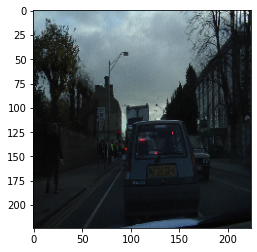

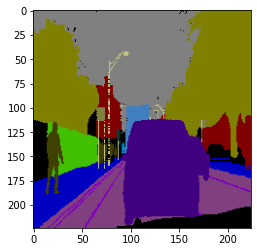

In [13]:
for i , j in train_dataset:
#     print(onehot2img(i))
    plt.imshow(i[0])
    plt.show()
    plt.imshow(onehot2img(j[0]))
    plt.show()
    break

# Define backbone model

In [14]:
inputs = Input((224,224,3))
# s = Lambda(lambda x: x / 255) (inputs)

# DownSample
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)
p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p5)
c6 = Dropout(0.3) (c6)
c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)
# p6 = MaxPooling2D(pool_size=(2, 2)) (c6)

# Upsample
u6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (c6)
u6 = concatenate([u6, c5])
c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c4])
c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c3])
c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c2], axis=3)
c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c9)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(32, (1, 1), activation='softmax') (c9)

model = Model(inputs=inputs, outputs=outputs)

# Define callbacks function

In [15]:
logdir = 'Unet_tensorboard/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir)

In [16]:
# os.makedirs("training_3", exist_ok=True)  ## NOTE for windows
# python3 -m tensorboard.main --logdir=./segmentation/Unet_tensorboard  ## command for show Tensorboard in ubuntu
ckpt_callback = ModelCheckpoint(filepath='Unet_checkpoint/weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss')

In [17]:
def scheduler(epoch):
    if epoch < 50:
        return 0.001
    elif epoch < 100:
        return 0.0001
    elif epoch < 150:
        return 0.00001
    elif epoch < 200:
        return 0.000001
    else:
        return 0.00001

learning_rate_scheduler = LearningRateScheduler(scheduler, verbose=1)

# Define f1_score

In [18]:
smooth =1
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f*y_true_f) + K.sum(y_pred_f*y_pred_f) + smooth)


# Compile model

In [19]:
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=[dice_coef,'accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 224, 224, 16  0           ['conv2d[0][0]']                 
                                )                                                             

 conv2d_transpose_2 (Conv2DTran  (None, 56, 56, 64)  32832       ['conv2d_15[0][0]']              
 spose)                                                                                           
                                                                                                  
 concatenate_2 (Concatenate)    (None, 56, 56, 128)  0           ['conv2d_transpose_2[0][0]',     
                                                                  'conv2d_5[0][0]']               
                                                                                                  
 conv2d_16 (Conv2D)             (None, 56, 56, 64)   73792       ['concatenate_2[0][0]']          
                                                                                                  
 dropout_8 (Dropout)            (None, 56, 56, 64)   0           ['conv2d_16[0][0]']              
                                                                                                  
 conv2d_17

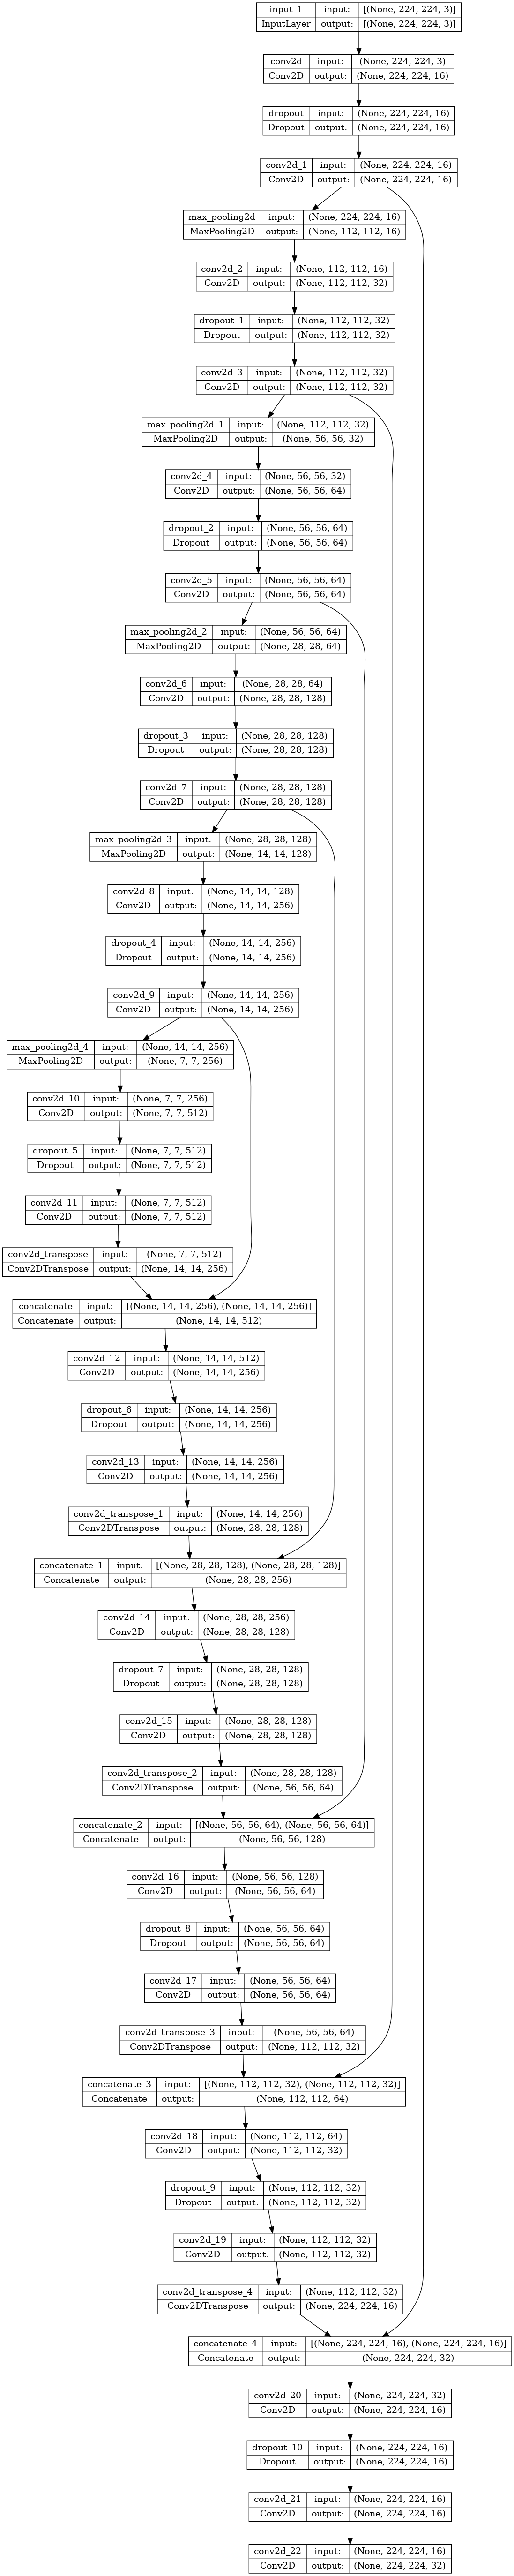

In [20]:
img_file = './architecture1.png'
tf.keras.utils.plot_model(model,to_file=img_file,show_shapes=True, show_layer_names=True)

# Fit model

In [21]:
history = model.fit(train_dataset , validation_data=val_dataset,
                    callbacks=[learning_rate_scheduler,tensorboard_callback,ckpt_callback] ,
                    epochs=300)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/300
369/369 [==============================] - 14s 25ms/step - loss: 1.8611 - dice_coef: 0.4647 - accuracy: 0.4494 - val_loss: 1.5445 - val_dice_coef: 0.6204 - val_accuracy: 0.5774 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/300
369/369 [==============================] - 9s 25ms/step - loss: 1.3711 - dice_coef: 0.6413 - accuracy: 0.6192 - val_loss: 1.4023 - val_dice_coef: 0.6500 - val_accuracy: 0.6029 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/300
369/369 [==============================] - 9s 25ms/step - loss: 1.2351 - dice_coef: 0.6824 - accuracy: 0.6458 - val_loss: 1.3318 - val_dice_coef: 0.6646 - val_accuracy: 0.6159 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/300
369/369 [==============================] - 9s 25ms/step - loss: 1.1271 - dice_coef: 0.7101 - accuracy: 0.6658 - val_loss: 1.2289


Epoch 32: LearningRateScheduler setting learning rate to 0.001.
Epoch 32/300
369/369 [==============================] - 10s 26ms/step - loss: 0.6782 - dice_coef: 0.8374 - accuracy: 0.8071 - val_loss: 0.8310 - val_dice_coef: 0.7992 - val_accuracy: 0.7661 - lr: 0.0010

Epoch 33: LearningRateScheduler setting learning rate to 0.001.
Epoch 33/300
369/369 [==============================] - 10s 25ms/step - loss: 0.6556 - dice_coef: 0.8442 - accuracy: 0.8147 - val_loss: 0.7751 - val_dice_coef: 0.8193 - val_accuracy: 0.7886 - lr: 0.0010

Epoch 34: LearningRateScheduler setting learning rate to 0.001.
Epoch 34/300
369/369 [==============================] - 10s 25ms/step - loss: 0.6315 - dice_coef: 0.8507 - accuracy: 0.8208 - val_loss: 0.7636 - val_dice_coef: 0.8173 - val_accuracy: 0.7865 - lr: 0.0010

Epoch 35: LearningRateScheduler setting learning rate to 0.001.
Epoch 35/300
369/369 [==============================] - 10s 26ms/step - loss: 0.6141 - dice_coef: 0.8555 - accuracy: 0.8267 - val_l

369/369 [==============================] - 10s 26ms/step - loss: 0.4889 - dice_coef: 0.8860 - accuracy: 0.8596 - val_loss: 0.5499 - val_dice_coef: 0.8775 - val_accuracy: 0.8505 - lr: 1.0000e-04

Epoch 63: LearningRateScheduler setting learning rate to 0.0001.
Epoch 63/300
369/369 [==============================] - 10s 26ms/step - loss: 0.4858 - dice_coef: 0.8865 - accuracy: 0.8601 - val_loss: 0.5450 - val_dice_coef: 0.8786 - val_accuracy: 0.8518 - lr: 1.0000e-04

Epoch 64: LearningRateScheduler setting learning rate to 0.0001.
Epoch 64/300
369/369 [==============================] - 10s 26ms/step - loss: 0.4831 - dice_coef: 0.8871 - accuracy: 0.8606 - val_loss: 0.5468 - val_dice_coef: 0.8785 - val_accuracy: 0.8518 - lr: 1.0000e-04

Epoch 65: LearningRateScheduler setting learning rate to 0.0001.
Epoch 65/300
369/369 [==============================] - 10s 25ms/step - loss: 0.4806 - dice_coef: 0.8878 - accuracy: 0.8614 - val_loss: 0.5454 - val_dice_coef: 0.8786 - val_accuracy: 0.8520 - lr

369/369 [==============================] - 10s 26ms/step - loss: 0.4310 - dice_coef: 0.8985 - accuracy: 0.8726 - val_loss: 0.5221 - val_dice_coef: 0.8859 - val_accuracy: 0.8595 - lr: 1.0000e-04

Epoch 93: LearningRateScheduler setting learning rate to 0.0001.
Epoch 93/300
369/369 [==============================] - 10s 26ms/step - loss: 0.4301 - dice_coef: 0.8988 - accuracy: 0.8731 - val_loss: 0.5197 - val_dice_coef: 0.8860 - val_accuracy: 0.8597 - lr: 1.0000e-04

Epoch 94: LearningRateScheduler setting learning rate to 0.0001.
Epoch 94/300
369/369 [==============================] - 10s 26ms/step - loss: 0.4280 - dice_coef: 0.8991 - accuracy: 0.8732 - val_loss: 0.5193 - val_dice_coef: 0.8867 - val_accuracy: 0.8602 - lr: 1.0000e-04

Epoch 95: LearningRateScheduler setting learning rate to 0.0001.
Epoch 95/300
369/369 [==============================] - 10s 26ms/step - loss: 0.4266 - dice_coef: 0.8994 - accuracy: 0.8736 - val_loss: 0.5194 - val_dice_coef: 0.8866 - val_accuracy: 0.8597 - lr

Epoch 122/300
369/369 [==============================] - 10s 26ms/step - loss: 0.4126 - dice_coef: 0.9025 - accuracy: 0.8769 - val_loss: 0.5067 - val_dice_coef: 0.8885 - val_accuracy: 0.8628 - lr: 1.0000e-05

Epoch 123: LearningRateScheduler setting learning rate to 1e-05.
Epoch 123/300
369/369 [==============================] - 10s 26ms/step - loss: 0.4106 - dice_coef: 0.9030 - accuracy: 0.8775 - val_loss: 0.5062 - val_dice_coef: 0.8888 - val_accuracy: 0.8632 - lr: 1.0000e-05

Epoch 124: LearningRateScheduler setting learning rate to 1e-05.
Epoch 124/300
369/369 [==============================] - 10s 26ms/step - loss: 0.4099 - dice_coef: 0.9031 - accuracy: 0.8776 - val_loss: 0.5061 - val_dice_coef: 0.8887 - val_accuracy: 0.8629 - lr: 1.0000e-05

Epoch 125: LearningRateScheduler setting learning rate to 1e-05.
Epoch 125/300
369/369 [==============================] - 10s 26ms/step - loss: 0.4107 - dice_coef: 0.9029 - accuracy: 0.8774 - val_loss: 0.5066 - val_dice_coef: 0.8886 - val_accu

Epoch 152/300
369/369 [==============================] - 10s 26ms/step - loss: 0.4051 - dice_coef: 0.9041 - accuracy: 0.8788 - val_loss: 0.5056 - val_dice_coef: 0.8889 - val_accuracy: 0.8632 - lr: 1.0000e-06

Epoch 153: LearningRateScheduler setting learning rate to 1e-06.
Epoch 153/300
369/369 [==============================] - 10s 26ms/step - loss: 0.4058 - dice_coef: 0.9040 - accuracy: 0.8784 - val_loss: 0.5053 - val_dice_coef: 0.8890 - val_accuracy: 0.8632 - lr: 1.0000e-06

Epoch 154: LearningRateScheduler setting learning rate to 1e-06.
Epoch 154/300
369/369 [==============================] - 10s 26ms/step - loss: 0.4058 - dice_coef: 0.9039 - accuracy: 0.8786 - val_loss: 0.5052 - val_dice_coef: 0.8890 - val_accuracy: 0.8632 - lr: 1.0000e-06

Epoch 155: LearningRateScheduler setting learning rate to 1e-06.
Epoch 155/300
369/369 [==============================] - 10s 26ms/step - loss: 0.4052 - dice_coef: 0.9041 - accuracy: 0.8789 - val_loss: 0.5051 - val_dice_coef: 0.8890 - val_accu

Epoch 182/300
369/369 [==============================] - 10s 26ms/step - loss: 0.4045 - dice_coef: 0.9043 - accuracy: 0.8788 - val_loss: 0.5048 - val_dice_coef: 0.8891 - val_accuracy: 0.8632 - lr: 1.0000e-06

Epoch 183: LearningRateScheduler setting learning rate to 1e-06.
Epoch 183/300
369/369 [==============================] - 10s 27ms/step - loss: 0.4047 - dice_coef: 0.9043 - accuracy: 0.8788 - val_loss: 0.5047 - val_dice_coef: 0.8891 - val_accuracy: 0.8633 - lr: 1.0000e-06

Epoch 184: LearningRateScheduler setting learning rate to 1e-06.
Epoch 184/300
369/369 [==============================] - 10s 26ms/step - loss: 0.4039 - dice_coef: 0.9043 - accuracy: 0.8791 - val_loss: 0.5047 - val_dice_coef: 0.8891 - val_accuracy: 0.8633 - lr: 1.0000e-06

Epoch 185: LearningRateScheduler setting learning rate to 1e-06.
Epoch 185/300
369/369 [==============================] - 10s 26ms/step - loss: 0.4039 - dice_coef: 0.9045 - accuracy: 0.8790 - val_loss: 0.5048 - val_dice_coef: 0.8891 - val_accu

Epoch 212/300
369/369 [==============================] - 10s 26ms/step - loss: 0.4044 - dice_coef: 0.9044 - accuracy: 0.8790 - val_loss: 0.5055 - val_dice_coef: 0.8890 - val_accuracy: 0.8632 - lr: 1.0000e-05

Epoch 213: LearningRateScheduler setting learning rate to 1e-05.
Epoch 213/300
369/369 [==============================] - 10s 27ms/step - loss: 0.4040 - dice_coef: 0.9044 - accuracy: 0.8789 - val_loss: 0.5055 - val_dice_coef: 0.8891 - val_accuracy: 0.8634 - lr: 1.0000e-05

Epoch 214: LearningRateScheduler setting learning rate to 1e-05.
Epoch 214/300
369/369 [==============================] - 10s 26ms/step - loss: 0.4029 - dice_coef: 0.9047 - accuracy: 0.8794 - val_loss: 0.5057 - val_dice_coef: 0.8893 - val_accuracy: 0.8635 - lr: 1.0000e-05

Epoch 215: LearningRateScheduler setting learning rate to 1e-05.
Epoch 215/300
369/369 [==============================] - 10s 26ms/step - loss: 0.4035 - dice_coef: 0.9045 - accuracy: 0.8791 - val_loss: 0.5052 - val_dice_coef: 0.8893 - val_accu

Epoch 242/300
369/369 [==============================] - 10s 26ms/step - loss: 0.3992 - dice_coef: 0.9056 - accuracy: 0.8803 - val_loss: 0.5044 - val_dice_coef: 0.8897 - val_accuracy: 0.8640 - lr: 1.0000e-05

Epoch 243: LearningRateScheduler setting learning rate to 1e-05.
Epoch 243/300
369/369 [==============================] - 10s 26ms/step - loss: 0.3989 - dice_coef: 0.9055 - accuracy: 0.8803 - val_loss: 0.5033 - val_dice_coef: 0.8899 - val_accuracy: 0.8642 - lr: 1.0000e-05

Epoch 244: LearningRateScheduler setting learning rate to 1e-05.
Epoch 244/300
369/369 [==============================] - 10s 26ms/step - loss: 0.3988 - dice_coef: 0.9056 - accuracy: 0.8802 - val_loss: 0.5029 - val_dice_coef: 0.8898 - val_accuracy: 0.8642 - lr: 1.0000e-05

Epoch 245: LearningRateScheduler setting learning rate to 1e-05.
Epoch 245/300
369/369 [==============================] - 10s 26ms/step - loss: 0.3991 - dice_coef: 0.9055 - accuracy: 0.8802 - val_loss: 0.5029 - val_dice_coef: 0.8897 - val_accu

Epoch 272/300
369/369 [==============================] - 10s 26ms/step - loss: 0.3942 - dice_coef: 0.9065 - accuracy: 0.8813 - val_loss: 0.5028 - val_dice_coef: 0.8902 - val_accuracy: 0.8645 - lr: 1.0000e-05

Epoch 273: LearningRateScheduler setting learning rate to 1e-05.
Epoch 273/300
369/369 [==============================] - 10s 26ms/step - loss: 0.3942 - dice_coef: 0.9065 - accuracy: 0.8813 - val_loss: 0.5028 - val_dice_coef: 0.8904 - val_accuracy: 0.8646 - lr: 1.0000e-05

Epoch 274: LearningRateScheduler setting learning rate to 1e-05.
Epoch 274/300
369/369 [==============================] - 10s 26ms/step - loss: 0.3945 - dice_coef: 0.9065 - accuracy: 0.8814 - val_loss: 0.5026 - val_dice_coef: 0.8903 - val_accuracy: 0.8645 - lr: 1.0000e-05

Epoch 275: LearningRateScheduler setting learning rate to 1e-05.
Epoch 275/300
369/369 [==============================] - 10s 26ms/step - loss: 0.3941 - dice_coef: 0.9066 - accuracy: 0.8815 - val_loss: 0.5025 - val_dice_coef: 0.8902 - val_accu

In [22]:
evaluate = model.evaluate(test_dataset)

232/232 [==============================] - 3s 11ms/step - loss: 0.6811 - dice_coef: 0.8543 - accuracy: 0.8211


# Resume model

In [23]:
# checkpoint_path = 'Unet_checkpoint/weights.500-0.54.hdf5'
# model = tf.keras.models.load_model(checkpoint_path)
# history = model.fit(train_dataset , validation_data=val_dataset,
#                     callbacks=[learning_rate_scheduler,tensorboard_callback,ckpt_callback] ,
#                     epochs=200)

# Save model

In [24]:
model.save('Unet_segmentation_model.hdf5')

# Show predict model Vs real image

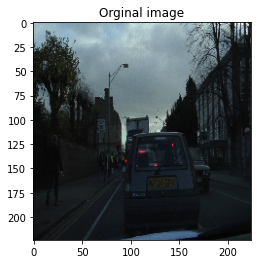

1/1 [==============================] - 0s 217ms/step


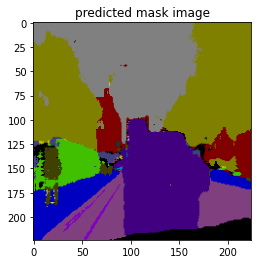

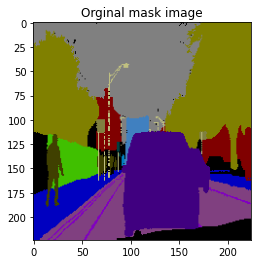

In [25]:
# img = load_img('./CamVid/train/train/frame/0001TP_009390.png')
for i , j in train_dataset:
    plt.title('Orginal image')
    plt.imshow(i[0])
    plt.show()
    img = model.predict(i)
    plt.title('predicted mask image')
    plt.imshow(onehot2img(img))
    plt.show()
    plt.title('Orginal mask image')
    plt.imshow(onehot2img(j[0]))
    plt.show()
    break
# print(np.shape(img))